# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


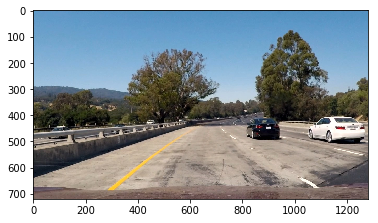

In [2]:
#reading in an image
image = mpimg.imread('CarND-Advanced-Lane-Lines-master/test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


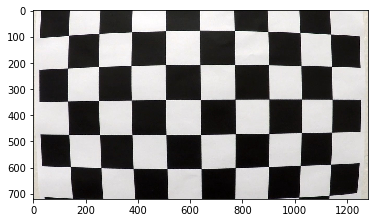

In [3]:
#reading in an image
image2 = mpimg.imread('CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg')

#printing out some stats and plotting
print('This image is:', type(image2), 'with dimensions:', image2.shape)
plt.imshow(image2) 

## Calibrate Cameras

<class 'numpy.ndarray'> (45, 1, 2)


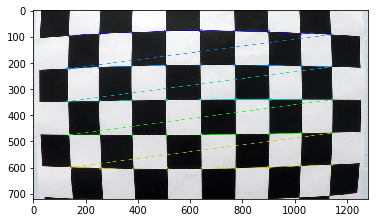

In [4]:
def find_corners(fname, nx, ny):
    # Make a list of calibration images
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return ret, corners, img

nx = 9
ny = 5
fname = 'CarND-Advanced-Lane-Lines-master/camera_cal/calibration1.jpg'
ret, corners, img = find_corners(fname, nx, ny)
plt.imshow(img)
print(type(corners),corners.shape)

<class 'numpy.ndarray'> (54, 1, 2)


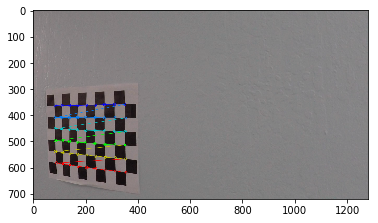

In [5]:
nx = 9
ny = 6
fname = 'CarND-Advanced-Lane-Lines-master/camera_cal/calibration20.jpg'
ret, corners, img = find_corners(fname, nx, ny)
plt.imshow(img)
print(type(corners),corners.shape)

In [6]:
%matplotlib qt

def calibrate(nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./CarND-Advanced-Lane-Lines-master/camera_cal/cal*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        ret, corners, img = find_corners(fname, nx, ny)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #write_name = './CarND-Advanced-Lane-Lines-master/camera_cal/calibrated_images/corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    #cv2.destroyAllWindows()
    return ret, mtx, dist, rvecs, tvecs


ret, mtx, dist, rvecs, tvecs = calibrate(nx, ny)

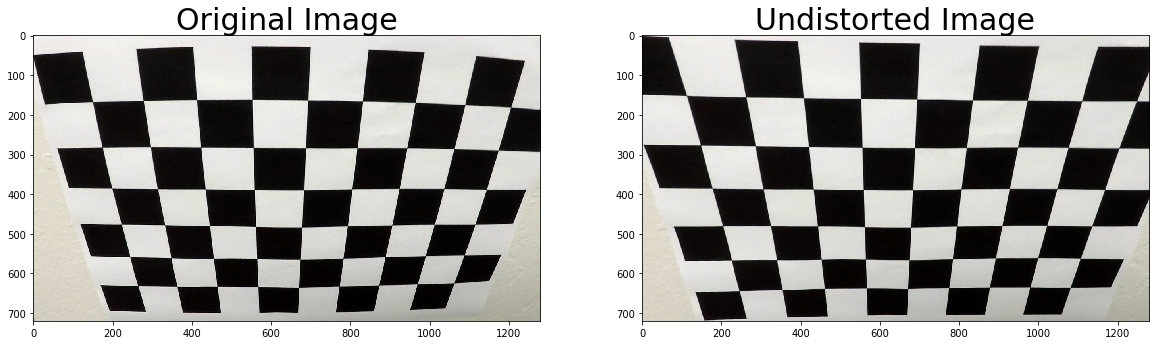

In [10]:
#Test the results of the calibration
img_original = mpimg.imread('./CarND-Advanced-Lane-Lines-master/camera_cal/calibration2.jpg')
img_undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

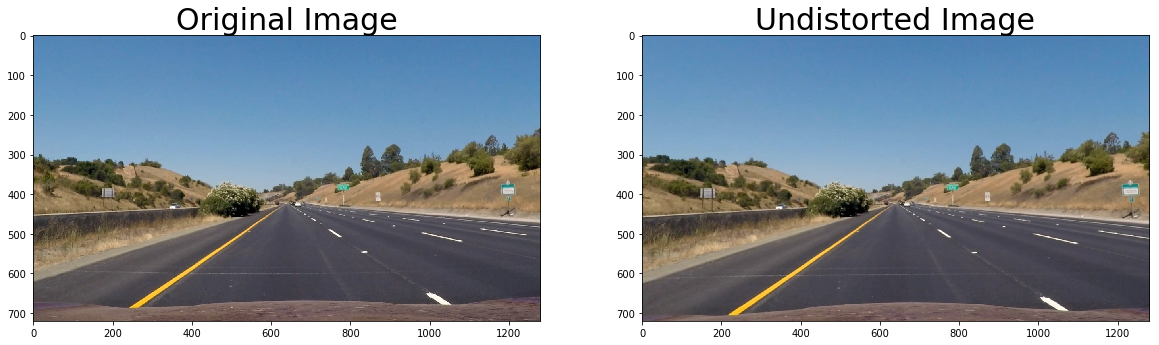

In [19]:
#Now to apply undistortion to actual road images
img_original = mpimg.imread('./CarND-Advanced-Lane-Lines-master/test_images/straight_lines1.jpg')
img_undistorted = cv2.undistort(img_original, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_original)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

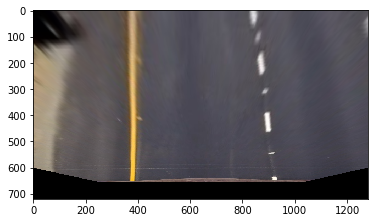

In [22]:
def perspective_transform(undistorted_image):
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[400,600],[600,450],[700,450],[925,600]])
    dst = np.float32([[400,600],[400,0],[925,0],[925,600]])
    # Given src and dst points, calculate the perspective transform matrix
    img_size = (undistorted_image.shape[1], undistorted_image.shape[0]) 
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undistorted_image, M, img_size)

    # Return the resulting image and matrix
    return warped, M

warped, M = perspective_transform(img_undistorted)
plt.imshow(warped)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

'''
Idea for drawing lines:
    Run the drawn lines back through the Hough transform and cluster points together with a ML clustering algorithm. 
    Take average of each of the clusters and print as a single line.
'''
def draw_lines(img, lines, color=[150, 0, 255], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines, line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

In [ ]:
#Trying out different images:
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
#Built my own Hough Transform
def simple_Hough_transform(lines):
    '''
    IN: Numpy array of lines defined by endpoints.(Output by the (modified) hough_lines function)
    OUT:Numpy array of a set of points in Hough space in the form (rho, theta).
    
    y = mx + b
    m = (y1 - y0)/(x1 - x0)
    b = y - mx
    '''
    lst = []
    for line in lines:
        x0 = line[0][0]
        y0 = line[0][1]
        x1 = line[0][2]
        y1 = line[0][3]
        
        m = (y1 - y0)/(x1 - x0)
            
        b = y0 - m*x0
        lst.append([m,b])
    return lst

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from collections import Counter

def kmeans_cluster(n,X):
    X = np.array(X)
    X = Imputer().fit_transform(X)
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    
    if kmeans.inertia_ > 300000:   #Gets rid of points from the smallest cluster.
        n = 3
        kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
        smallest_group_label = list(Counter(kmeans.labels_).keys())[-1:][0]
        for i,hough_point in enumerate(X):
            if kmeans.labels_[i] == smallest_group_label:
                X_1 = np.delete(X, i, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X_1)
        X = X_1
    if kmeans.inertia_ > 20000:  #Again at a lower threshold.
        n = 3
        kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
        smallest_group_label = list(Counter(kmeans.labels_).keys())[-1:][0]
        for i,hough_point in enumerate(X):
            if kmeans.labels_[i] == smallest_group_label:
                X_1 = np.delete(X, i, 0)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(X_1)
        X = X_1     
    return kmeans.cluster_centers_ , kmeans.inertia_

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Grayscale the image
gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
top_right_vertex = (525,310)
top_left_vertex = (460,310)
bottow_right_vertex = (910,imshape[0])
bottom_left_vertex = (80,imshape[0])
vertices = np.array([[bottom_left_vertex,top_left_vertex, top_right_vertex, bottow_right_vertex]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 3    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines, line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = weighted_img(color_edges, line_image, α=0.8, β=1., λ=0.)
#plt.imshow(lines_edges)
plt.imshow(lines_edges)

In [ ]:
#Run a simple Hough transform and plot the points to see the clusters that define similar lines.
'''
I used rectangular coordinants becuase they are easier for me to impliment, but this could be converted to a polar
#version pretty easily.
'''
X = np.array(simple_Hough_transform(lines))
print(X.T)
plt.scatter(X.T[0],X.T[1])
plt.title('All lines in Hough Space')
plt.xlabel('m (Slope)')
plt.ylabel('b (Intercept)')
plt.show()

In [ ]:
'''
Implimenting K-Means clustering to average the lines various lines together into n distinct lines.
Set n: number of lines that will be detected (this may need to tuned depending on the situation).
'''
n = 2 #This assumes that we are expecting to find exactly two lines in the polygon.
Z = simple_Hough_transform(lines)
centers, inertia = kmeans_cluster(n,Z)
plt.scatter(X.T[0],X.T[1])
plt.scatter(centers.T[0],centers.T[1])
plt.title('K-means Cluster Centers')
plt.xlabel('m (Slope)')
plt.ylabel('b (Intercept)')
plt.show()
print(centers.T)

In [ ]:
#Convert back to lines in x,y space, defined by endpoints.
# y = mx + b
# x = (y-b)/m
final_lines = []
y_1 = 540 #Cropping at bottom of image.
y_0 = 310 #Cropping at the horizon.
print(centers)
for hough_point in centers:
    x_0 = int((y_0 - hough_point[1])/(hough_point[0]))
    x_1 = int((y_1 - hough_point[1])/(hough_point[0]))
    final_lines.append([[x_0,y_0,x_1,y_1]])
    
print(final_lines)

In [ ]:
#Now to plot the lines on the orginal image.
image_copy = np.copy(image)
draw_lines(image_copy, final_lines)
'''
lines_edges = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
plt.imshow(lines_edges)
'''
plt.imshow(image_copy)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
'''
This function is essential a copy of the code from several of the 
above cells in order to group the whole pipline into a single function.
Some changes have been made so that it will generalize better.
'''
def process_image(image):
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    imshape = image.shape
    top_left = (.50*imshape[1],.57*imshape[0])   #Trimming to percentages of the total image size.
    top_right = (.50*imshape[1],.57*imshape[0])
    bottom_left = (.10*imshape[1],.92*imshape[0])
    bottom_right = (.90*imshape[1],.92*imshape[0])
    vertices = np.array([[bottom_left,top_left, top_right, bottom_right]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 3    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    lines, line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    color_edges = np.dstack((edges, edges, edges)) 
    lines_edges = weighted_img(color_edges, line_image, α=0.8, β=1., λ=0.)


    n = 2 #This assumes that we are expecting to find exactly two lines in the polygon.
    Z = simple_Hough_transform(lines)
    Z = np.nan_to_num(Z) 
    
    centers, inertia = kmeans_cluster(n,Z)      
    if inertia < 50000:         #Sets the line color based on the error in the k-means clusters.
        color = [0, 255, 0]
    elif inertia < 300000:
        color = [255, 255, 51]
    else:
        color = [255, 0, 0]
    
    final_lines = []
    y_1 = int(imshape[0]) #Cropping at bottom of image.
    y_0 = int(0.6*imshape[0]) #Cropping at the horizon.
    for hough_point in centers:
        if hough_point[0] == 0:     #prevents infinity values
            hough_point[0] = .01
        x_0 = int((y_0 - hough_point[1])/(hough_point[0]))
        x_1 = int((y_1 - hough_point[1])/(hough_point[0]))
        final_lines.append([[x_0,y_0,x_1,y_1]])
    image_copy = np.copy(image)
    draw_lines(image_copy, final_lines, color)
    return image_copy

In [ ]:
processed_image = process_image(image)
plt.imshow(processed_image)

Let's try the one with the solid white lane on the right first ...

In [ ]:

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))


## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))